In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import livelossplot
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
import operator

## Preparing data

In [4]:
kitchenware = pickle.load(open('/content/drive/My Drive/Proyecto/dataset/training_dataset_all.pkl', 'rb'))
kitchenware.values.shape

(45173, 3)

In [5]:
objects = list(kitchenware.label.value_counts().keys())
kitchenware.label.value_counts()

tostadora    6152
hervidor     5785
cuchara      4620
tenedor      4543
cuenco       4369
sarten       4200
taza         4026
cuchillo     3989
pelador      3766
ruido        3723
Name: label, dtype: int64

In [0]:
def dataEqualize(df):
  '''Equals the number of training data per object by deleting data randomly'''
  df['idx'] = df.index
  for obj in objects:
    delete = df.label.value_counts().values[0]-min(df.label.value_counts().values)
    if delete > 0:
      provisional = df[df.label == obj]
      todrop = random.sample(range(min(provisional.index),max(provisional.index)),delete)
      df.drop(df.idx[todrop],inplace=True)
  df.drop(columns='idx',inplace=True)
  df = df.reset_index(drop=True)
  return df

In [0]:
kitchenware = dataEqualize(kitchenware)

In [8]:
kitchenware.values.shape

(37230, 3)

In [9]:
kitchenware.label.value_counts()

taza         3723
cuchara      3723
cuchillo     3723
tostadora    3723
cuenco       3723
pelador      3723
tenedor      3723
ruido        3723
sarten       3723
hervidor     3723
Name: label, dtype: int64

In [0]:
dummies = pd.get_dummies(kitchenware['label'])

In [11]:
dummies.head()

,cuchara,cuchillo,cuenco,hervidor,pelador,ruido,sarten,taza,tenedor,tostadora
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


In [0]:
dummies['gt'] = dummies.apply(lambda x: pd.Series([x.values]), axis=1)

In [13]:
dummies.head()

,cuchara,cuchillo,cuenco,hervidor,pelador,ruido,sarten,taza,tenedor,tostadora,gt
0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


## Model training

In [0]:
X = np.stack(kitchenware['image'])
y = np.stack(dummies['gt'])

In [41]:
print(X.shape)
print(y.shape)

(37230, 64, 64, 3)
(37230, 10)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
num_classes = 10
img_rows = 64
img_cols = 64

In [0]:
# Incoming data is in uint8. Cast the input data images to be floats in range [0.0-1.0]  
#X_train = X_train.astype('float32') / 255
#X_test = X_test.astype('float32') / 255

In [45]:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train shape: (29784, 64, 64, 3)
29784 train samples
7446 test samples
(7446, 64, 64, 3)
(29784, 10)
(7446, 10)


In [46]:
model = Sequential()
chanDim = -1

if K.image_data_format() == "channels_first":
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(28))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.summary()


# CNN params
plot_losses = livelossplot.PlotLossesKeras()

EPOCHS = 18
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

#Training the model

model.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 21, 21, 64)       

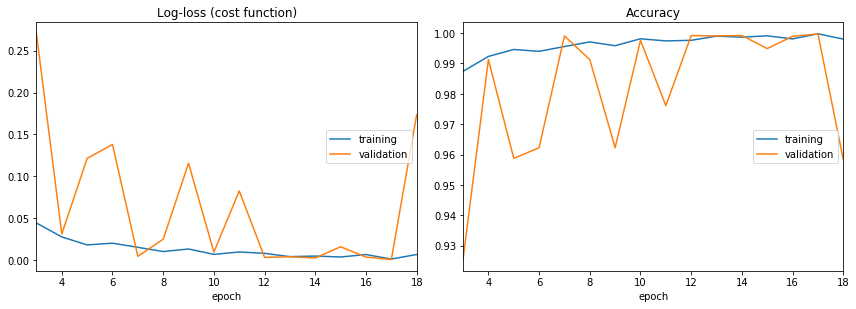

Log-loss (cost function):
training   (min:    0.001, max:    0.446, cur:    0.007)
validation (min:    0.001, max:    0.270, cur:    0.173)

Accuracy:
training   (min:    0.868, max:    1.000, cur:    0.998)
validation (min:    0.925, max:    1.000, cur:    0.958)


In [47]:
# Fit the NN
%time
model.fit(X_train, y_train,
        batch_size=BS,
        epochs=EPOCHS,
        callbacks=[plot_losses],
        verbose=1,
        validation_data=(X_test, y_test))

## Cheking model accuracy

In [48]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Accuracy: 95.84%
Test loss: 0.17341502626325705
Test accuracy: 0.9583669083591689


In [0]:
Y_pred = model.predict(X_test)

[6 6 5 ... 9 5 3]
[6 6 5 ... 9 5 3]


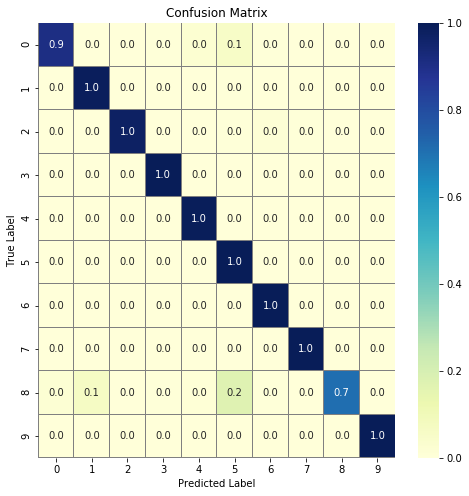

In [50]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show();

Cheking on test sample

In [0]:
class_names = list(dummies.columns)[:-1]

[2.1199818e-13 7.9060931e-07 2.2110227e-09 3.9704069e-08 2.4875393e-11
 3.9955950e-10 9.9999893e-01 1.9946354e-07 2.0959862e-10 1.1846224e-09]
cuchara: 0.0
cuchillo: 0.0
cuenco: 0.0
hervidor: 0.0
pelador: 0.0
ruido: 0.0
sarten: 1.0
taza: 0.0
tenedor: 0.0
tostadora: 0.0
(1, 64, 64, 3)


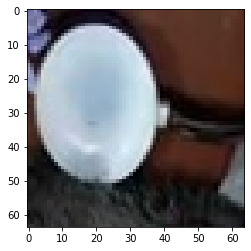

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

img = X_test[150]
pred = model.predict(np.expand_dims(img,axis=0))[0]
print(pred)
for obj in class_names:
    print(f'{obj}: {round(pred[class_names.index(obj)],2)}')
print(np.expand_dims(img,axis=0).shape)
plt.imshow(img);

Cheking on outsider sample

In [0]:
def test(img):
  '''Preparing data and returning prediction'''
  class_names = ['cuchara','cuchillo','cuenco','hervidor','pelador','ruido','sarten','taza','tenedor','tostadora']
  image = cv2.imread(img)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(64,64))
  image = image.astype('float32') / 255
  pred = model.predict(np.expand_dims(image,axis=0))[0]
  predictions = {}
  for obj in class_names:
      predictions[obj] = pred[class_names.index(obj)]
  print(f'{max(predictions.items(), key=operator.itemgetter(1))[0]}: {max(predictions.items(), key=operator.itemgetter(1))[1]}')
  plt.imshow(image);

ruido: 0.5428909063339233


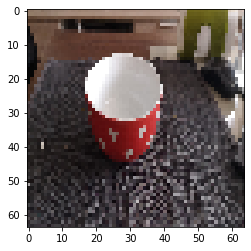

In [66]:
test('/content/drive/My Drive/Proyecto/dataset/new_data/cuenco.jpg')

ruido: 0.6116907000541687


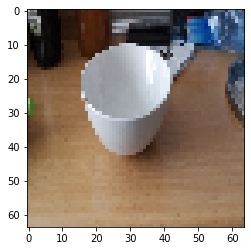

In [67]:
test('/content/drive/My Drive/Proyecto/dataset/new_data/cuenco2.jpg')

tostadora: 0.4835655093193054


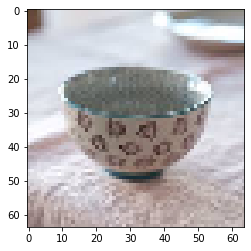

In [68]:
test('/content/drive/My Drive/Proyecto/dataset/new_data/cuenco3.jpeg')

ruido: 0.7220897674560547


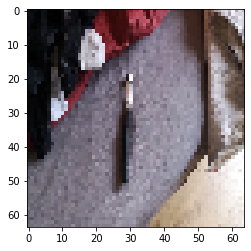

In [69]:
test('/content/drive/My Drive/Proyecto/dataset/new_data/pelador.jpg')

tostadora: 0.4870299696922302


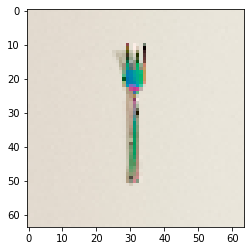

In [70]:
test('/content/drive/My Drive/Proyecto/dataset/new_data/tenedor.jpg')